# 성능개선 기법 실습

# 모듈 정의

## train.py
- 모델 학습과 검증 함수 정의

In [1]:
import os
os.makedirs('module', exist_ok=True)

In [59]:
%%writefile module/train.py

import torch
import time

# multi와 binary 정확도 계산이 다르다.

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset) # 전체 데이터수
    num_batches = len(dataloader)  #  step 수
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_batches
        test_accuracy /= size  #전체 개수로 나눈다.
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_batches
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) #총 데이터수

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



#### LR scheduler를 받아서 적용.
def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True,
        save_model_path=None, early_stopping=True, patience=10, device='cpu', 
        mode:"binary or multi"='binary', 
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate 스케쥴러 객체. default: None
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        ## train() 호출
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ## 검증 - test_xxxx_classification() 함수 호출
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)
        
        ####### LR Scheduler에게 lr 변경요청.
        if lr_scheduler:
            lr_scheduler.step()
        
        #현 에폭의 검증결과를 각 list에 추가.
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        # 로그 출력
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py
- dataset 생성 함수 제공 모듈

In [3]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, 
                             transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


In [5]:
from module import data

In [7]:
mnist_trainloader = data.load_mnist_dataset("datasets", 200, True)
mnist_testloader = data.load_mnist_dataset("datasets", 200, False)

In [9]:
# 데이터수
len(mnist_trainloader.dataset), len(mnist_testloader.dataset)

(60000, 10000)

In [10]:
# step수
len(mnist_trainloader), len(mnist_testloader)

(300, 50)

# import

In [24]:
import torch
import torch.nn as nn

import torchinfo

from module import train, data

import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 하이퍼파라미터, 변수 정의

In [25]:
LR = 0.001
N_EPOCH = 10
BATCH_SIZE = 200

# DATASET, MODEL 저장할 ROOT 디렉토리 경로
DATASET_ROOT_PATH = 'datasets'
MODEL_SAVE_ROOT_PATH = "models"

# Data 준비

## mnist 데이터 로딩

In [26]:
train_loader = data.load_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, True)
test_loader = data.load_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, False)

# 모델의 크기 변경에 따른 성능변화

In [14]:
class SmallSizeModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.output = nn.Linear(784, 10) 
        #in: feature수 - (1*28*28), out: class개수(10)
        
    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.output(out)
        return out

In [15]:
# 모델생성
small_model = SmallSizeModel()
torchinfo.summary(small_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SmallSizeModel                           [200, 10]                 --
├─Linear: 1-1                            [200, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 1.57
Input size (MB): 0.63
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.67

In [16]:
# loss
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(small_model.parameters(), lr=LR)

In [20]:
# train -> module.fit()
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = \
 train.fit(train_loader, test_loader, small_model, loss_fn, optimizer,
           N_EPOCH, 
           save_best_model=True,
           save_model_path=os.path.join(MODEL_SAVE_ROOT_PATH, "small_model.pth"),
           device=device, 
           mode="multi")

Epoch[1/10] - Train loss: 0.44681 Train Accucracy: 0.88638 || Validation Loss: 0.42821 Validation Accuracy: 0.89480
저장: 1 - 이전 : inf, 현재: 0.4282137756049633
Epoch[2/10] - Train loss: 0.35757 Train Accucracy: 0.90423 || Validation Loss: 0.34324 Validation Accuracy: 0.90930
저장: 2 - 이전 : 0.4282137756049633, 현재: 0.3432376080751419
Epoch[3/10] - Train loss: 0.32480 Train Accucracy: 0.91292 || Validation Loss: 0.31501 Validation Accuracy: 0.91450
저장: 3 - 이전 : 0.3432376080751419, 현재: 0.31500717155635355
Epoch[4/10] - Train loss: 0.30456 Train Accucracy: 0.91662 || Validation Loss: 0.29750 Validation Accuracy: 0.91720
저장: 4 - 이전 : 0.31500717155635355, 현재: 0.2975003752857447
Epoch[5/10] - Train loss: 0.29274 Train Accucracy: 0.91898 || Validation Loss: 0.28716 Validation Accuracy: 0.92130
저장: 5 - 이전 : 0.2975003752857447, 현재: 0.28715726137161257
Epoch[6/10] - Train loss: 0.28374 Train Accucracy: 0.92172 || Validation Loss: 0.28003 Validation Accuracy: 0.92140
저장: 6 - 이전 : 0.28715726137161257, 현재

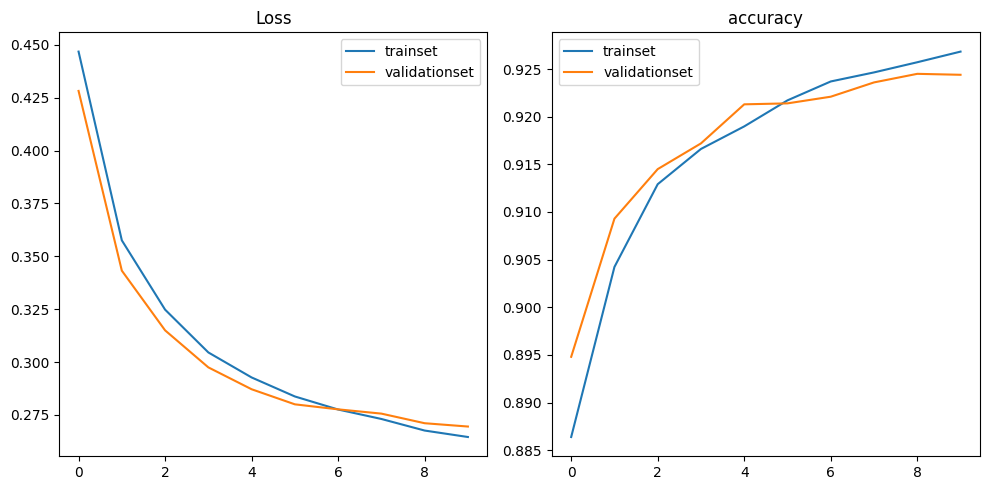

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="trainset")
plt.plot(valid_loss_list, label="validationset")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="trainset")
plt.plot(valid_acc_list, label="validationset")
plt.title("accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
## nn.Sequential()을 이용해 Layer block 정의하기.
### 여러 Layer들을 묶어준다.
layer_block = nn.Sequential(
    nn.Linear(20, 30), 
    nn.ReLU()
)

a = torch.ones(1, 20)
r = layer_block(a)
r.shape
r

tensor([[0.0000, 0.0914, 0.2362, 0.9255, 0.0000, 1.4532, 0.1495, 0.0000, 0.0380,
         0.0000, 0.4439, 0.0000, 0.0816, 0.5717, 0.2854, 0.0000, 1.0030, 0.0000,
         0.0000, 0.0000, 0.5847, 0.4762, 0.1715, 0.6298, 0.0000, 0.2919, 0.2303,
         0.1810, 0.1375, 0.1486]], grad_fn=<ReluBackward0>)

In [ ]:
# self.block = nn.Sequential(nn.Linear(784, 2048), nn.ReLU(),nn.Linear(2048, 1024), nn.ReLU())

In [38]:
class BigSizeModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):
        X = nn.Flatten()(X)
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        return self.output(out)

In [39]:
big_model = BigSizeModel()
torchinfo.summary(big_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BigSizeModel                             [200, 10]                 --
├─Sequential: 1-1                        [200, 2048]               --
│    └─Linear: 2-1                       [200, 2048]               1,607,680
│    └─ReLU: 2-2                         [200, 2048]               --
├─Sequential: 1-2                        [200, 1024]               --
│    └─Linear: 2-3                       [200, 1024]               2,098,176
│    └─ReLU: 2-4                         [200, 1024]               --
├─Sequential: 1-3                        [200, 512]                --
│    └─Linear: 2-5                       [200, 512]                524,800
│    └─ReLU: 2-6                         [200, 512]                --
├─Sequential: 1-4                        [200, 256]                --
│    └─Linear: 2-7                       [200, 256]                131,328
│    └─ReLU: 2-8                         [200, 256]          

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=LR)

In [41]:
# 학습
train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2 = \
 train.fit(train_loader, test_loader, big_model, loss_fn, optimizer,
           N_EPOCH, 
           save_best_model=True,
           save_model_path=os.path.join(MODEL_SAVE_ROOT_PATH, "big_model.pth"),
           device=device, 
           mode="multi")

Epoch[1/10] - Train loss: 0.13750 Train Accucracy: 0.96020 || Validation Loss: 0.16077 Validation Accuracy: 0.95120
저장: 1 - 이전 : inf, 현재: 0.16076712200418114
Epoch[2/10] - Train loss: 0.07145 Train Accucracy: 0.97855 || Validation Loss: 0.09932 Validation Accuracy: 0.97000
저장: 2 - 이전 : 0.16076712200418114, 현재: 0.09931544862687587
Epoch[3/10] - Train loss: 0.04715 Train Accucracy: 0.98652 || Validation Loss: 0.08683 Validation Accuracy: 0.97510
저장: 3 - 이전 : 0.09931544862687587, 현재: 0.08683011617744342
Epoch[4/10] - Train loss: 0.04086 Train Accucracy: 0.98798 || Validation Loss: 0.08575 Validation Accuracy: 0.97750
저장: 4 - 이전 : 0.08683011617744342, 현재: 0.08574712981935591
Epoch[5/10] - Train loss: 0.03441 Train Accucracy: 0.98938 || Validation Loss: 0.09194 Validation Accuracy: 0.97680
Epoch[6/10] - Train loss: 0.03013 Train Accucracy: 0.99112 || Validation Loss: 0.08522 Validation Accuracy: 0.97710
저장: 6 - 이전 : 0.08574712981935591, 현재: 0.08521976359654218
Epoch[7/10] - Train loss: 0.01

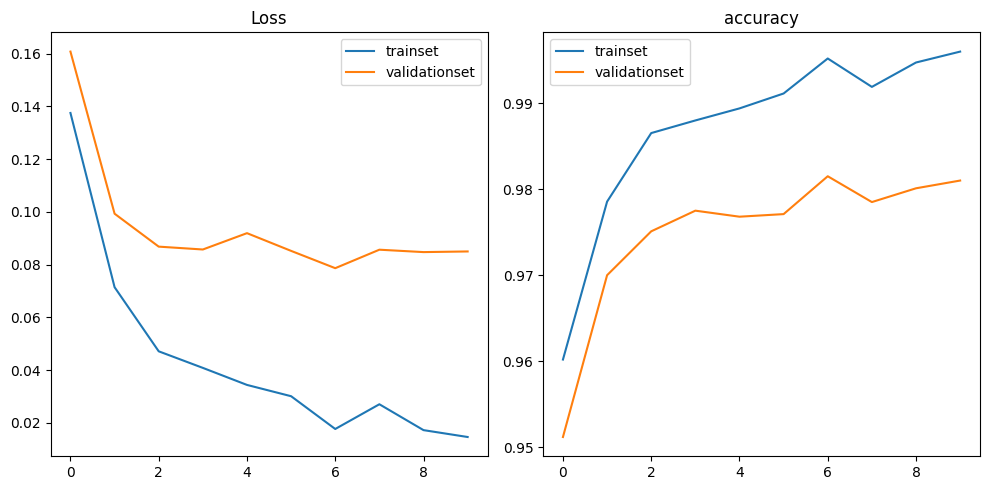

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list2, label="trainset")
plt.plot(valid_loss_list2, label="validationset")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list2, label="trainset")
plt.plot(valid_acc_list2, label="validationset")
plt.title("accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout 예제
- dropout 각 레이어에 적용
    - dropout은 nn.Dropout 객체를 사용
    - 객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    - Drop시킬 노드를 가진 Layer 뒤에 추가한다.

In [7]:
class DropoutModel(nn.Module):
    
    def __init__(self, drop_rate=0.5):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(784, 256), 
                                nn.ReLU(), 
                                nn.Dropout(p=drop_rate))
        
        self.b2 = nn.Sequential(nn.Linear(256, 256), 
                                nn.ReLU(), 
                                nn.Dropout(p=drop_rate))
        
        self.b3 = nn.Sequential(nn.Linear(256, 128), 
                                nn.ReLU(), 
                                nn.Dropout(p=drop_rate))
        
        self.b4 = nn.Sequential(nn.Linear(128, 128), 
                                nn.ReLU(), 
                                nn.Dropout(p=drop_rate))
        
        self.output = nn.Sequential(nn.Linear(128, 10), 
                                    nn.Dropout(p=drop_rate))
    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.output(out)
        return out

In [9]:
d_model = DropoutModel().to(device)  # drop_rate=0.5(default)
torchinfo.summary(d_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [200, 10]                 --
├─Sequential: 1-1                        [200, 256]                --
│    └─Linear: 2-1                       [200, 256]                200,960
│    └─ReLU: 2-2                         [200, 256]                --
│    └─Dropout: 2-3                      [200, 256]                --
├─Sequential: 1-2                        [200, 256]                --
│    └─Linear: 2-4                       [200, 256]                65,792
│    └─ReLU: 2-5                         [200, 256]                --
│    └─Dropout: 2-6                      [200, 256]                --
├─Sequential: 1-3                        [200, 128]                --
│    └─Linear: 2-7                       [200, 128]                32,896
│    └─ReLU: 2-8                         [200, 128]                --
│    └─Dropout: 2-9                      [200, 128]                --
├─

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(d_model.parameters(), lr=LR)

result = train.fit(train_loader, test_loader, d_model, loss_fn, optimizer, 
                   N_EPOCH, save_best_model=False, early_stopping=False, 
                   device=device, mode="multi")

Epoch[1/10] - Train loss: 0.28728 Train Accucracy: 0.93027 || Validation Loss: 0.27686 Validation Accuracy: 0.93170
Epoch[2/10] - Train loss: 0.21552 Train Accucracy: 0.94947 || Validation Loss: 0.21538 Validation Accuracy: 0.94790
Epoch[3/10] - Train loss: 0.18287 Train Accucracy: 0.96102 || Validation Loss: 0.19133 Validation Accuracy: 0.96010
Epoch[4/10] - Train loss: 0.14524 Train Accucracy: 0.96652 || Validation Loss: 0.15666 Validation Accuracy: 0.96300
Epoch[5/10] - Train loss: 0.13934 Train Accucracy: 0.96833 || Validation Loss: 0.15643 Validation Accuracy: 0.96100
Epoch[6/10] - Train loss: 0.11858 Train Accucracy: 0.97273 || Validation Loss: 0.13297 Validation Accuracy: 0.96840
Epoch[7/10] - Train loss: 0.10632 Train Accucracy: 0.97520 || Validation Loss: 0.12374 Validation Accuracy: 0.96970
Epoch[8/10] - Train loss: 0.09749 Train Accucracy: 0.97640 || Validation Loss: 0.11951 Validation Accuracy: 0.97200
Epoch[9/10] - Train loss: 0.09994 Train Accucracy: 0.97753 || Validation

In [16]:
a = torch.randn(5, 3)
ln = nn.Linear(3, 4)
b = ln(a)
do = nn.Dropout(0.5)
c = do(b)

In [18]:
a # input
b # linear 

tensor([[-0.9113, -1.2459, -0.7458, -1.4852],
        [-0.5906, -0.2701,  0.2253, -0.7967],
        [-0.8237, -0.8124, -0.1907, -1.2559],
        [-0.2970,  0.1195,  0.5034, -0.3445],
        [-0.6746, -0.4074,  0.3721, -0.9877]], grad_fn=<AddmmBackward0>)

In [19]:
c

tensor([[-1.8226, -0.0000, -1.4916, -2.9704],
        [-1.1813, -0.0000,  0.4505, -0.0000],
        [-1.6474, -0.0000, -0.3813, -2.5119],
        [-0.5940,  0.2389,  0.0000, -0.0000],
        [-1.3492, -0.0000,  0.0000, -0.0000]], grad_fn=<MulBackward0>)

# Batch Normalization
- Dense => BN => Activation

In [27]:
# Linear -> BatchNorm -> Activation (-> Dropout)
class BNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Linear(784, 256),
                                nn.BatchNorm1d(256), # 입력: 1차원 -> feature수
                                nn.ReLU()
                               )
        self.b2 = nn.Sequential(nn.Linear(256, 128), 
                                nn.BatchNorm1d(128), 
                                nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(128, 64), 
                                nn.BatchNorm1d(64), 
                                nn.ReLU())
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.output(out)
        return out

In [28]:
# 모델 생성
bn_model = BNModel().to(device)
torchinfo.summary(bn_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BNModel                                  [200, 10]                 --
├─Sequential: 1-1                        [200, 256]                --
│    └─Linear: 2-1                       [200, 256]                200,960
│    └─BatchNorm1d: 2-2                  [200, 256]                512
│    └─ReLU: 2-3                         [200, 256]                --
├─Sequential: 1-2                        [200, 128]                --
│    └─Linear: 2-4                       [200, 128]                32,896
│    └─BatchNorm1d: 2-5                  [200, 128]                256
│    └─ReLU: 2-6                         [200, 128]                --
├─Sequential: 1-3                        [200, 64]                 --
│    └─Linear: 2-7                       [200, 64]                 8,256
│    └─BatchNorm1d: 2-8                  [200, 64]                 128
│    └─ReLU: 2-9                         [200, 64]                 --


In [23]:
# train
# loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bn_model.parameters(), lr=LR)

result_bn = train.fit(train_loader, test_loader, bn_model, loss_fn, optimizer,
                     N_EPOCH, save_best_model=False, early_stopping=False, 
                     device=device, mode='multi')

Epoch[1/10] - Train loss: 0.08264 Train Accucracy: 0.97880 || Validation Loss: 0.10226 Validation Accuracy: 0.97120
Epoch[2/10] - Train loss: 0.06351 Train Accucracy: 0.98172 || Validation Loss: 0.09605 Validation Accuracy: 0.97000
Epoch[3/10] - Train loss: 0.03272 Train Accucracy: 0.99047 || Validation Loss: 0.07481 Validation Accuracy: 0.97760
Epoch[4/10] - Train loss: 0.02647 Train Accucracy: 0.99198 || Validation Loss: 0.07090 Validation Accuracy: 0.97850
Epoch[5/10] - Train loss: 0.02051 Train Accucracy: 0.99367 || Validation Loss: 0.07033 Validation Accuracy: 0.97920
Epoch[6/10] - Train loss: 0.01278 Train Accucracy: 0.99647 || Validation Loss: 0.06803 Validation Accuracy: 0.97970
Epoch[7/10] - Train loss: 0.00891 Train Accucracy: 0.99768 || Validation Loss: 0.06280 Validation Accuracy: 0.98080
Epoch[8/10] - Train loss: 0.01320 Train Accucracy: 0.99617 || Validation Loss: 0.07372 Validation Accuracy: 0.97970
Epoch[9/10] - Train loss: 0.00924 Train Accucracy: 0.99728 || Validation

# Learning rate decay

### Optimizer와 Learning rate scheduler의 속성, 메소드 확인
- 파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.

In [ ]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)

In [31]:
##  옵티마이저 객체관련 여러 정보들을 조회 => optimizer.param_groups
print(type(optimizer.param_groups), len(optimizer.param_groups))
print(type(optimizer.param_groups[0]))
info_dict = optimizer.param_groups[0]
info_dict.keys()

<class 'list'> 1
<class 'dict'>


dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])

In [32]:
info_dict['lr']  # 현재 learning rate

0.001

In [35]:
### 학습률의 변화흐름을 시각화하는 함수
def plot_lr(title, lr_list):
    # title - 그래프 제목
    # lr_list - 에폭별로 적용된 Learning rate을 담은 리스트
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(lr_list)), lr_list)
    
    plt.title(title)
    plt.xticks([x for x in range(len(lr_list)) if x % 5 == 0], rotation=45)
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.grid(True, 
             axis="x", # x축 기준 그리드만 표시
             linestyle=":")
    plt.show()

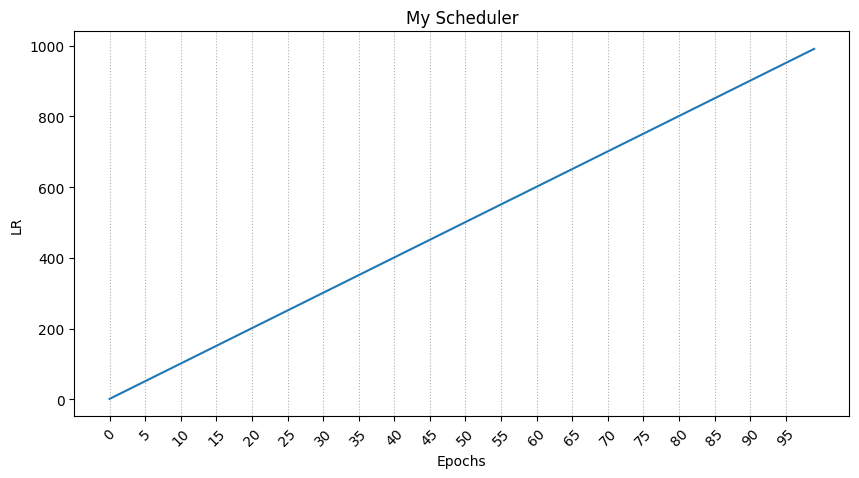

In [36]:
# 테스트
plot_lr("My Scheduler", list(range(1, 1000, 10)))

#### StepLR

In [38]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001) 
# lr_scheduler : optimizer의 lr는 초기 학습률
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, # 학습률을 변화시킬 Optimizer
                                                 step_size=30, # 몇 step/epoch 마다 LR을 변경시킬지 간격
                                                 gamma=0.5, # 변경 비율. new_lr = 현재_lr * gamma
                                                )
# optimizer의 lr를 30 에폭/step 마다 0.5 배씩 변경

In [40]:
# 현재 LR 조회
optimizer.param_groups[0]['lr'], step_scheduler.get_last_lr()

(0.001, [0.001])

In [41]:
N_EPOCH = 200
STEP_SIZE = 10
steplr_list = []  # epoch별 lr 를 저장할 변수.

for epoch in range(N_EPOCH):
    
    # step
    for step in range(STEP_SIZE):  # for x, y in dataloader:
        # 학습
        # 모델 예측 -> Loss 계산 -> 파라미터 업데이트
        optimizer.step()
        # learning rate 변경 요청. => 30번 요청이 들어오면 변경 * gamma
        ## step단위로 변경.
        # step_scheduler.step()  
    step_scheduler.step()    # epoch 단위로 변경.
    steplr_list.append(step_scheduler.get_last_lr()[0])  # 현재 epoch의 lr를 저장.

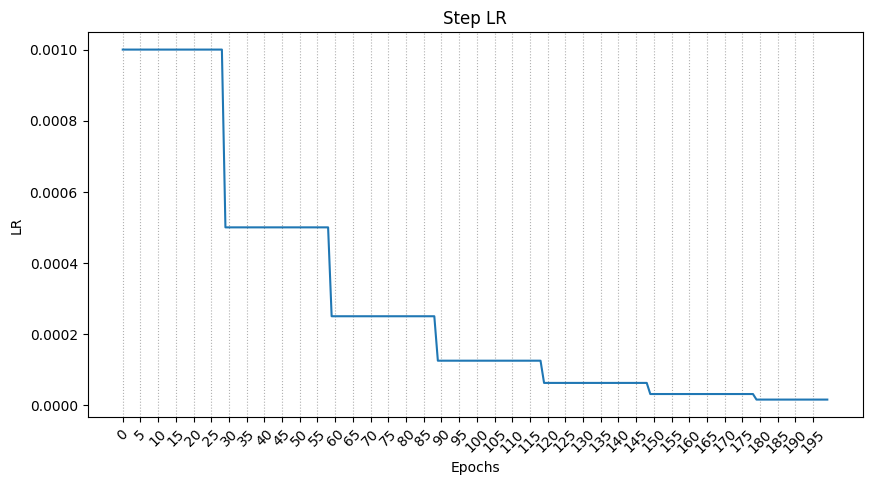

In [42]:
plot_lr("Step LR", steplr_list)

#### CosineAnnealingLR
cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.

In [46]:
# Annealing : 가열 <-> 냉각
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)
ca_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                          T_max=10, # 한 cycle 주기(단위: 에폭, step)
                                                          eta_min=0.00001, # 최소 학습률.
                                                         )
# 범위: 초기 LR  ~  eta_min

In [47]:
ca_lr_list = []
for epoch in range(N_EPOCH):
    # 한 에폭
    for step in range(STEP_SIZE):
        # 한 스텝
        optimizer.step()
    
    ca_scheduler.step()
    ca_lr_list.append(ca_scheduler.get_last_lr()[0])

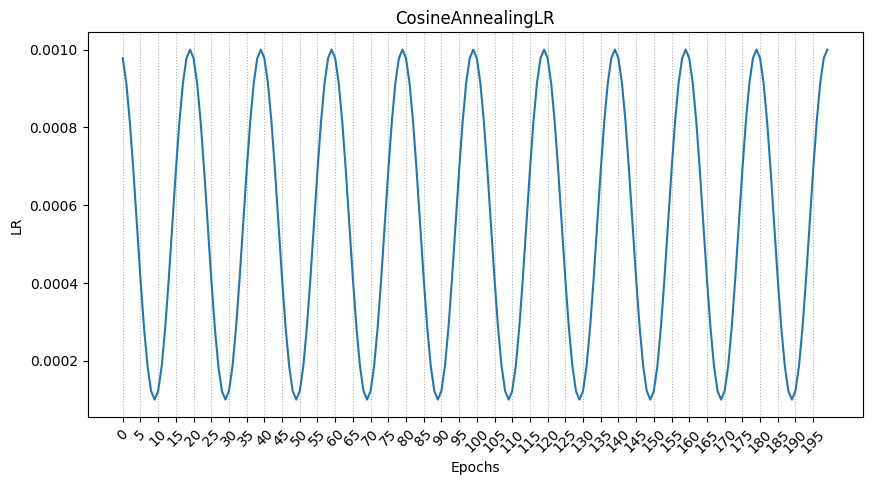

In [48]:
plot_lr("CosineAnnealingLR", ca_lr_list)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)

In [61]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)
caws_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10, # 초기 변화 주기(cycle)
    T_mult=2, # 변화주기를 어떤 비율로 변경할지. T_0 * T_mult = 새주기
    eta_min=1e-5 # 0.00001. 최소학습률
    , verbose=True # 학습률 변경할때 마다 로그 출력
)
# 변화 범위: 초기 학습률 ~ eta_min

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


In [62]:
caws_lr_list = []

for epoch in range(N_EPOCH):
    # 한 에폭
    for step in range(STEP_SIZE):
        # 한 스텝
        optimizer.step()
    caws_scheduler.step()
    caws_lr_list.append(caws_scheduler.get_last_lr()[0])

Epoch 00001: adjusting learning rate of group 0 to 9.7577e-04.
Epoch 00002: adjusting learning rate of group 0 to 9.0546e-04.
Epoch 00003: adjusting learning rate of group 0 to 7.9595e-04.
Epoch 00004: adjusting learning rate of group 0 to 6.5796e-04.
Epoch 00005: adjusting learning rate of group 0 to 5.0500e-04.
Epoch 00006: adjusting learning rate of group 0 to 3.5204e-04.
Epoch 00007: adjusting learning rate of group 0 to 2.1405e-04.
Epoch 00008: adjusting learning rate of group 0 to 1.0454e-04.
Epoch 00009: adjusting learning rate of group 0 to 3.4227e-05.
Epoch 00010: adjusting learning rate of group 0 to 1.0000e-03.
Epoch 00011: adjusting learning rate of group 0 to 9.9391e-04.
Epoch 00012: adjusting learning rate of group 0 to 9.7577e-04.
Epoch 00013: adjusting learning rate of group 0 to 9.4605e-04.
Epoch 00014: adjusting learning rate of group 0 to 9.0546e-04.
Epoch 00015: adjusting learning rate of group 0 to 8.5502e-04.
Epoch 00016: adjusting learning rate of group 0 to 7.95

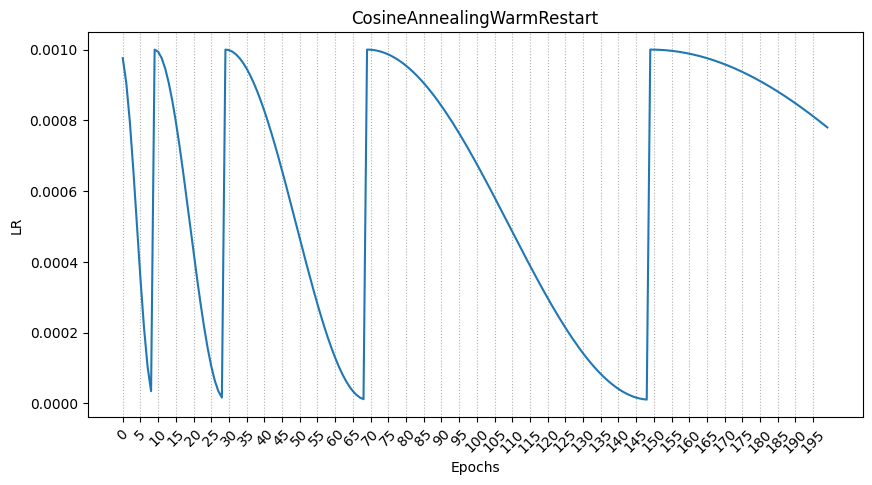

In [58]:
plot_lr("CosineAnnealingWarmRestart", caws_lr_list)